##### This model follows the same fine tuning process as model 08, but with a change in the model optimizer. Previous models have used the transformers tool 'create_optimizer' to set up the optimizer recommended in referenced Hugging Face tutorials. Based on documentation, this optimizer appears to utilize 'adam' in the backend, but I am curious to see if there is a change between using this set up versus just the usual 'adam' optimizer alone.

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read in data

In [4]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [5]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

## Tokenize data

In [6]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=1024, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=1024, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [7]:
tokenized_data = data.map(preprocess_function)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-09e4e2a19ffda2e7.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-33199c6e54546ed7.arrow


0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [8]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [9]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynmaically pad inputs and labels

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [11]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Compile model

In [12]:
model.compile(optimizer='adam')

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [13]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

In [14]:
model_history = model.fit(tf_train, validation_data=tf_validation, callbacks=[early_stop], epochs=25)

Epoch 1/25
212/212 [==============================] - 31s 101ms/step - loss: 5.4499 - val_loss: 4.9146
Epoch 2/25
212/212 [==============================] - 20s 95ms/step - loss: 4.3285 - val_loss: 4.8186
Epoch 3/25
212/212 [==============================] - 19s 91ms/step - loss: 3.6931 - val_loss: 4.9039
Epoch 4/25
212/212 [==============================] - 19s 91ms/step - loss: 3.0674 - val_loss: 5.2131
Epoch 5/25
212/212 [==============================] - 20s 93ms/step - loss: 2.4337 - val_loss: 5.5558
Epoch 6/25
212/212 [==============================] - 20s 93ms/step - loss: 1.8494 - val_loss: 6.0162
Epoch 7/25
212/212 [==============================] - 19s 91ms/step - loss: 1.3655 - val_loss: 6.4418
Epoch 7: early stopping


# Visualize model

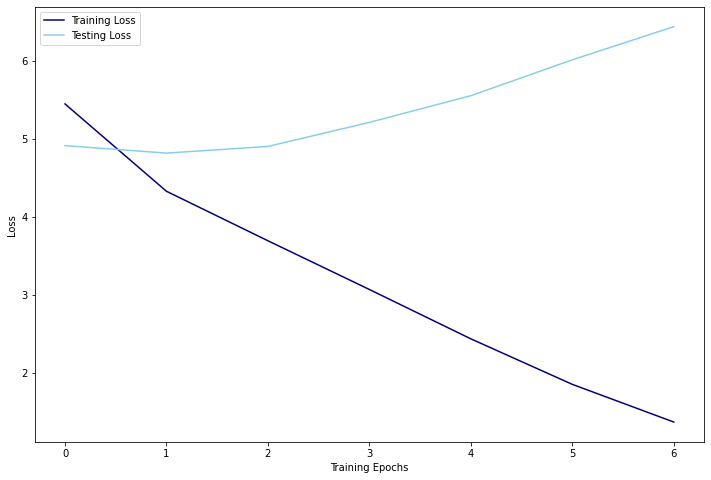

In [15]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss for the validation data in the model is muchhigher than the loss for the training data, and they appear to be very rapidly diverging, indicating that the model is overfitting. The difference in the loss functions of this model is greater than that of model 8.

# Rouge scores for training data

In [16]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [30:21<00:00,  8.59s/it]


In [17]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 78.72340425531915
recall: 7.198443579766536
f-measure: 13.19073083778966
***************
rouge2
precision: 26.08695652173913
recall: 2.3391812865497075
f-measure: 4.293381037567084
***************
rougeL
precision: 46.808510638297875
recall: 4.280155642023346
f-measure: 7.843137254901962
***************
rougeLsum
precision: 76.59574468085107
recall: 7.003891050583658
f-measure: 12.83422459893048
***************


# Rouge scores for test data

In [18]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [19]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [08:12<00:00,  8.34s/it]


In [20]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 57.14285714285714
recall: 3.4934497816593884
f-measure: 6.584362139917695
***************
rouge2
precision: 15.384615384615385
recall: 0.8771929824561403
f-measure: 1.6597510373443984
***************
rougeL
precision: 35.714285714285715
recall: 2.1834061135371177
f-measure: 4.11522633744856
***************
rougeLsum
precision: 42.857142857142854
recall: 2.6200873362445414
f-measure: 4.938271604938271
***************


# Example model-generated summaries

In [21]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [22]:
print(rand_indexes)

[51, 55, 29]


In [23]:
print(test_labels[51])

Dante tells us the shape of the Eighth Circle; he calls it Malebolge, evil pouches.
Each "pouch," or bolgia, goes all the way around the yet deeper pit that yawns in the center, and each one holds a different kind of sinner.
Dante and Virgil cross each bolgia by a spur of rock that forms a bridge over it.
Around the bottom of  Pouch, lashed by horned demons, go the panders and seducers.
Among the panders in  Bolgia is someone Dante recognizes who confesses that is true that he made his sister sleep with a powerful nobleman, and among the seducers is Jason, the "hero" who brought back the Golden Fleece to Greece, using and leaving several women in the process.
In  Bolgia, plunged in what looks and smells like excrement from human outhouses, are the flatterers.
Analysis No one in either of these bolgias asks to be remembered when Dante returns to the world; their sins, which involve either betraying innocent women or using the uniquely human gift of speech to manipulate rather than to te

In [24]:
print(test_preds[51])

In the Ninth Bolgia, Monte Cristo has become a member of the Crusades.


In [25]:
print(test_labels[55])

Archer and May begin their round of betrothal visits by calling on May's family matriarch, Catherine Manson Mingott, at her home.
Mrs Mingott cannot go upstairs because of her obesity, and has arranged her sitting room on the ground floor, with her bedroom in full view of guests.
This shockingly recalls "scenes in French fiction, and architectural incentives to immorality such as the simple American had never dreamed of.
That was how women with lovers lived in the wicked old societies.." It amuses Archer to think of "her blameless life led in the stage-setting of adultery" (Chapter 4, p. 24).
To everyone's relief, Ellen Olenska is not present when the betrothed couple arrive.
Mrs Mingott gives the couple her blessing and asks when the wedding will be.
Mrs Welland offers a show of reluctance to hurry it.
Ellen enters with Julius Beaufort.
Archer tells her about the engagement, which she already knows of.
As she bids him goodbye, she asks him to come and visit her.
After the Wellands lea

In [26]:
print(test_preds[55])

Viola's daughter, has been taken out of the house of Lady Catherine's house, and she finds her love with her.


In [27]:
print(test_labels[29])

Two of Mr. Sikes cohorts are waiting inside, Toby Crackit and Barney.
They eat dinner and go to sleep for a time.
At one they wake up and set out to rob the house they planned.
Mr. Sikes threatens Oliver more and they explain to him his job of going through the small window and opening the door.
Once Oliver realizes that he is going to be stealing, he begs and pleads to be set free to die in the fields.
Sikes puts a gun to his head and is ready to pull the trigger when Toby grabs Oliver and says it would be quieter to break his neck.
Sikes instructs the boy to do his job, pushes him through the cellar window, and hands him a lantern.
Just as Oliver is about to run through the house and wake the family, two men burst in on him and fire a gun.
Sikes warns him off, but when Oliver does not move, Sikes grabs him by the collar and drags him out through the window, which he came.
Sikes realizes that Oliver has been shot in the arm, and carries him away exclaiming at the loss of blood.
Oliver

In [28]:
print(test_preds[29])

Mr. Sowerberry runs into Oliver, and Mr. Bumble, and tries to talk him out of his father.


# Evaluation of model

Based on rouge scores, this model did not perform better than the baseline. The Rouge2 score is very slightly higher than the baseline, but all other scores are lower.